In [2]:
import sys
import util
from Polygenic_score import *

import os
import subprocess
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import re

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def clump_sorted_snps(bfile, assoc_file, snp_values, sorted_snps):

    clump_out = assoc_file[:assoc_file.index(".assoc")] + "_clump"
    cmd_plink_clump = "plink --bfile {} --clump {} --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out {} ".format(bfile,
            assoc_file,
            clump_out)
    print cmd_plink_clump
    p = subprocess.Popen(cmd_plink_clump, shell=True)
    p.wait()

    clumped_res = pd.read_table(clump_out+".clumped", delim_whitespace=True)
    clumped_snps = set(clumped_res.SNP)

    clumped_sorted_snps = np.array([i for i in sorted_snps if snp_values[i] in clumped_snps])
    return clumped_sorted_snps



In [4]:
def save_strat(strat_file, strat):
    pca_res = pd.read_table(strat_file, delim_whitespace=True, skiprows=1, header=None)
    PCs_out = strat + ".PCs"
    with open(PCs_out, "a") as f:
        f.write(', '.join(pca_res[0].values))
        f.write('\n')
        f.write(str(pca_res[2].values.tolist())[1:-1])
        f.write('\n')
        f.write(str(pca_res[3].values.tolist())[1:-1])
        f.write('\n')


In [5]:
def plink_prune(plink_bfile):

    cmd_prune = """plink --bfile {} --exclude /home/vcabeli/Documents/data/high-LD-regions_37.txt --range --indep-pairwise 50 5 0.2 --allow-extra-chr --out {}""".format(plink_bfile, plink_bfile+"_prune")
    p = subprocess.Popen(cmd_prune, shell=True)
    assert(p.wait() == 0)

    cmd_extract = """plink --bfile {} --extract {} --allow-extra-chr --chr 1-23 --make-bed --out {}""".format(plink_bfile, plink_bfile + "_prune.prune.in", 
                             plink_bfile + "_pruned")
    p = subprocess.Popen(cmd_extract, shell=True)
    assert(p.wait() == 0)

    print "Wrote {} bed/bim/fam.".format(plink_bfile + "_pruned")



In [6]:
def write_cov_file(pca_file,nb_pc):

    cmd_sed = "sed -i -e \"s/:/ /g\" -e \"s/\s\+/\t/g\" -e \"s/^\s\+//g\" {}".format(pca_file)
    p = subprocess.Popen(cmd_sed, shell=True)
    assert(p.wait()==0)
    
    cov_file = pca_file[:-9]+".cov"
    a=""
    for i in range(nb_pc):
        a=a+("\tPC{}".format(i+1))
    

    cmd_print = "printf \"FID\tIID{}\n\" > {}".format(a,cov_file)

    p = subprocess.Popen(cmd_print, shell=True)
    assert(p.wait()==0)

    cmd_tail = "tail -n+2 {} | cut -f1-{} >> {}".format(pca_file, 2+nb_pc, cov_file) 

    #-n+2 récup lignes en commançant par le 2ème
    #-f1-2+nb_pc résup les champs 1-nb_pc+2
    
    p = subprocess.Popen(cmd_tail, shell=True)
    assert(p.wait()==0)
    
    print "Wrote {}".format(cov_file)

In [11]:
def iterate(snp_data, pheno,n_iter,threshs,thresh_LD,nb_pc):
    res_hw_pval_sign = np.zeros([n_iter, len(threshs)])
    
    for iteration in range(n_iter):

        print "=========================Iteration {}=========================".format(iteration+1)
        
        # extraction des SNPs indépendantes selon le seuil de LD
        cmd_extract_low_ld_snps = "plink --bfile {} --extract {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                             "L2_thresh_{}_BP.extract".format(thresh_LD),
                                                                                             "low_ld")
        print cmd_extract_low_ld_snps
        p = subprocess.Popen(cmd_extract_low_ld_snps, shell=True)
        assert(p.wait()==0)

        plink_prune("low_ld")


 
        # Covariables
        if(nb_pc!=0):
            cmd_smart_pca2 = "smartpca.perl -i {} -a {} -b {} -o {} -p {} -e {} -l {} -k {} -t {} -m {}".format("low_ld_pruned.bed",
                                                                                                           "low_ld_pruned.bim",
                                                                                                           "low_ld_pruned.fam",
                                                                                                           "low_ld_pruned.pca",
                                                                                                           "low_ld_pruned.plot",
                                                                                                           "low_ld_pruned.eval",
                                                                                                           "low_ld_pruned.log",
                                                                                                           nb_pc, 2, 0)
            print cmd_smart_pca2
            p = subprocess.Popen(cmd_smart_pca2, shell=True)
            p.wait()


            write_cov_file("low_ld_pruned.pca.evec",nb_pc)
            save_strat("low_ld_pruned.pca.evec", "low_ld{}".format(thresh_LD)) #OUTPUT LINE

        
        # #### Split training / testing datasets
        train_idces = np.random.choice(np.arange(snp_data.row_count), size=int(snp_data.row_count*0.5), replace=False)
        test_idces = np.setdiff1d(np.arange(snp_data.row_count), train_idces, assume_unique=True)




        training_sample_out = "training_samples.keep"

        with open(training_sample_out, 'w') as f:
            for i in train_idces:
                f.write(pheno['iid'][i][0] + "\t" + pheno['iid'][i][1])
                f.write("\n")




        # #### Build training set bed bim fam


        #creation fichier plink (bam,bed,fam) avec les données d'apprentissage seulement
        cmd_keep_plink = "plink --bfile {} --keep {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                 training_sample_out,
                                                                                 "training_set")
        print cmd_keep_plink
        p = subprocess.Popen(cmd_keep_plink, shell=True)
        p.wait()





        #test d'association: classification (Rlog)
        if (nb_pc==0):
            cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --out {}".format("training_set","low_ld")
        elif (nb_pc==1):
            cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1 --out {}".format("training_set",
                                                                                                           "low_ld_pruned.cov",
                                                                                                           "low_ld")
        else:
            cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1-PC{} --out {}".format("training_set",
                                                                                                           "low_ld_pruned.cov",
                                                                                                            nb_pc,
                                                                                                           "low_ld")
        print cmd_second_gwas
        p = subprocess.Popen(cmd_second_gwas, shell=True)
        p.wait()
        low_ld_res = pd.read_table("low_ld.assoc.logistic", delim_whitespace=True)


        # clump les SNPs pour garder les SNPs indépendantes 
        sorted_snps_low_ld = np.argsort(low_ld_res.P)
        sorted_snps_low_ld = clump_sorted_snps("training_set", "low_ld.assoc.logistic",
                                               snp_data.col, sorted_snps_low_ld)

        
        # #### Coded genotype (hardy-weinberg)
        # 
        # With sufficiently large cohorts, traning and test sets should have the same MAFs. 
        # The coded genotype is computed on the whole dataset.




        G_hw = snp_data.val.copy()

        MAFs = np.nansum(2-G_hw, axis=0, ) / (np.count_nonzero(~np.isnan(G_hw), axis=0) * 2)
        G_hw = (2-G_hw - 2*MAFs)/np.sqrt(2*MAFs*(1-MAFs))

        # ### Compute PRS
        
        prs_low_ld = polygen_score_sign(G_hw, sorted_snps_low_ld,
                                        threshs,
                                        test_idces, pheno,
                                        low_ld_res.BETA)
        res_hw_pval_sign[iteration] = prs_low_ld
        
        ###### Compute I-score
        #i_scores_classification = util.get_i_scores_binary()

        #df_iscore = pd.DataFrame({'SNP':snp_data.col, 'i_score':i_scores_classification})
        #data frame a 2 colone (pê recupe que la deuxieme)
        #res_hw_iscore[iteration] = df_iscore
        
        ####### Compute LD-score 
        
    return(res_hw_pval_sign)

Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
========================= 0 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.05it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.98it/s]


========================= 10 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 10 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC10 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.06it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 10 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC10 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.30it/s]


========================= 20 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 20 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC20 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.19it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 20 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC20 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:04<00:00, 19.09it/s]


========================= 30 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 30 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC30 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.42it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 30 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC30 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.54it/s]


========================= 40 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 40 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC40 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.99it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 40 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC40 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.99it/s]


========================= 50 PCs =========================
=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 50 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC50 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.98it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 50 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC50 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 95/95 [00:05<00:00, 18.70it/s]


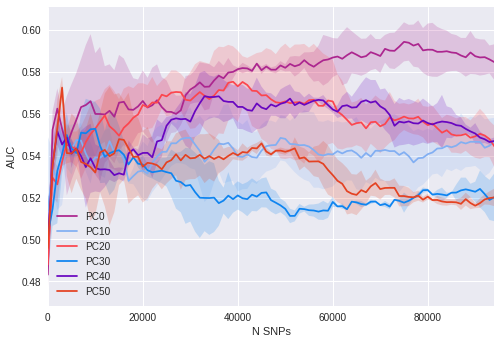

In [12]:
if __name__ == '__main__':

    snp_data, pheno = util.load_data("/home/vcabeli/Documents/data/BP_final/BP.B37-final")
    #imputed data (données par chromosome: "/home/vcabeli/Documents/data/BP_final_imputed/0.5_info/merged/plink/bedbimfam/BP.B37-imputed.chr{}.merged.1KG_P3.EURMAF0.005.0.5_info".format(chrom)
    n_iter = 2
    threshs = range(10, 95000, 1000)
    thresh_LD = 5
    nb_pc_tot=51
    time = range(10,95000,1000)
    get_color = lambda : "#" + "".join(np.random.choice(list("02468acef"), size=6))
    step = 10
    ############
    for PC in range(0,nb_pc_tot,step):
        print "========================= {} PCs =========================".format(PC)
        res_pval=iterate(snp_data, pheno,n_iter,threshs,thresh_LD,PC)


        for i in range(len(time)):
            res_pval[res_pval[:,i] == 0,i] = np.nan
            res_pval[np.isnan(res_pval[:,i]),i] = np.nanmedian(res_pval[:,i])
        sns.tsplot(np.power(res_pval,1),color=get_color(),ci=[0,95],time=time, condition="PC{}".format(PC))

    sns.plt.ylabel('AUC')
    sns.plt.xlabel('N SNPs')
    #sns.plt.savefig("fct_pc.pdf", format="pdf")

    #print "Wrote {}.".format("fct_pc.pdf")
    plt.show()


In [14]:
#Autre axes de représententaion AUC vs. nPCs


array([[ 0.49010554,  0.53131732,  0.53957178,  0.56746992,  0.5303309 ,
         0.52205224,  0.52904795,  0.52377091,  0.51946213,  0.50882332,
         0.5118794 ,  0.52253032,  0.51580088,  0.50659025,  0.51302317,
         0.52593135,  0.5286546 ,  0.51705357,  0.51937135,  0.52106582,
         0.51766479,  0.51950449,  0.52424899,  0.52700854,  0.52395246,
         0.52675438,  0.52889061,  0.5306819 ,  0.52377696,  0.52832781,
         0.52878168,  0.52886035,  0.53051851,  0.52691777,  0.5290419 ,
         0.52766818,  0.53162596,  0.53320544,  0.53558979,  0.5383312 ,
         0.53781075,  0.53762315,  0.53915422,  0.54228898,  0.54081843,
         0.54746315,  0.54392898,  0.54182905,  0.54299097,  0.54391687,
         0.5432875 ,  0.54326935,  0.54880056,  0.54435259,  0.54353562,
         0.54159304,  0.54430418,  0.54489724,  0.54705768,  0.54498802,
         0.54131466,  0.53824647,  0.53647939,  0.53416766,  0.53120234,
         0.53097843,  0.53291496,  0.52806153,  0.5

================================================================================================================

In [8]:
def polygen_score_sign(geno, sorted_snps, threshs, test_idces, pheno, betas) :

    auc = np.zeros(len(threshs))
    n_samples = len(test_idces)
    n_snps = max(threshs)+1
    sorted_snps = sorted_snps[:n_snps]
    test_cases = [i for i,j in enumerate(test_idces) if pheno['vals'][j]==2]
    #print(len(test_cases))
    test_controls = [i for i,j in enumerate(test_idces) if pheno['vals'][j]==1]
    #print(len(test_controls))
    betas = betas.values[sorted_snps]
    # geno = vecteur de taille m (nb snp) de marqueurs du code génétique [du groupe test] [trié par p-value]
    # np.nan_to_num = Replace nan with zero and inf with large finite numbers.
    polygen_score_test = np.multiply(np.nan_to_num(geno[test_idces][:,sorted_snps]),
                                     np.sign(np.nan_to_num(betas)))
    polygen_score_test = polygen_score_test.cumsum(axis=1)
    #print "val",polygen_score_test[:,140][1]

    # score polygénique calculer sur 70000 snps mais auc tout les 140(=len(threshs)) snps (lisse la courbe)
    # top score polygénique tout les 140 snps
    for i, top in enumerate(tqdm(threshs)):
        TPR = np.zeros(n_samples)
        FPR = np.zeros(n_samples)
        for idx, val in enumerate(polygen_score_test[:,top]):
            #print polygen_score_test[test_cases,top]>val
            #print np.count_nonzero(polygen_score_test[test_cases,top]>val) / len(test_cases)
            TPR[idx] = 1.0*np.count_nonzero(polygen_score_test[test_cases,top]>val) / len(test_cases) ##############PQ??????????
            FPR[idx] = 1.0*np.count_nonzero(polygen_score_test[test_controls,top]>val) / len(test_controls)
        auc[i] = sklearn.metrics.auc(x=FPR, y=TPR,reorder=True)

    return auc

In [43]:
snp_data, pheno = util.load_data("low_ld")

Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 9804 SNPs.


Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --extract L2_thresh_5_BP.extract --make-bed --out low_ld
Wrote low_ld_pruned bed/bim/fam.
smartpca.perl -i low_ld_pruned.bed -a low_ld_pruned.bim -b low_ld_pruned.fam -o low_ld_pruned.pca -p low_ld_pruned.plot -e low_ld_pruned.eval -l low_ld_pruned.log -k 2 -t 2 -m 0
Wrote low_ld_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --logistic sex beta hide-covar --covar low_ld_pruned.cov --covar-name PC1-PC2 --out low_ld
plink --bfile training_set --clump low_ld.assoc.logistic --clump-p1 1 --clump-p2 1 --clump-r2 0.2 --clump-kb 500 --out low_ld_clump 


100%|██████████| 70/70 [00:03<00:00, 19.13it/s]


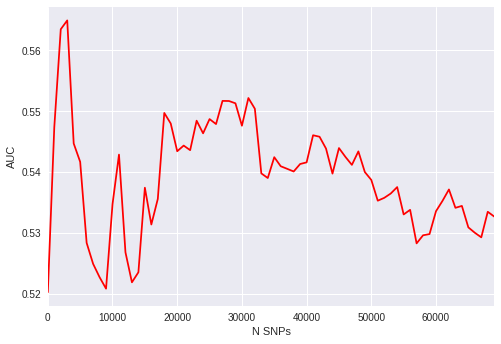

In [49]:
threshs = range(10, 70000, 1000)
thresh_LD = 5
##################################
snp_data, pheno = util.load_data("/home/vcabeli/Documents/data/BP_final/BP.B37-final")
#imputed data (données par chromosome: "/home/vcabeli/Documents/data/BP_final_imputed/0.5_info/merged/plink/bedbimfam/BP.B37-imputed.chr{}.merged.1KG_P3.EURMAF0.005.0.5_info".format(chrom)



# extraction des SNPs indépendantes selon le seuil de LD
cmd_extract_low_ld_snps = "plink --bfile {} --extract {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                     "L2_thresh_{}_BP.extract".format(thresh_LD),
                                                                                     "low_ld")
print cmd_extract_low_ld_snps
p = subprocess.Popen(cmd_extract_low_ld_snps, shell=True)
assert(p.wait()==0)

plink_prune("low_ld")



# Covariables
cmd_smart_pca2 = "smartpca.perl -i {} -a {} -b {} -o {} -p {} -e {} -l {} -k {} -t {} -m {}".format("low_ld_pruned.bed",
                                                                                                   "low_ld_pruned.bim",
                                                                                                   "low_ld_pruned.fam",
                                                                                                   "low_ld_pruned.pca",
                                                                                                   "low_ld_pruned.plot",
                                                                                                   "low_ld_pruned.eval",
                                                                                                   "low_ld_pruned.log",
                                                                                                   2, 2, 0)
print cmd_smart_pca2
p = subprocess.Popen(cmd_smart_pca2, shell=True)
p.wait()


write_cov_file("low_ld_pruned.pca.evec",2)
save_strat("low_ld_pruned.pca.evec", "low_ld{}".format(thresh_LD)) #OUTPUT LINE





################séparation test/app


train_idces = np.random.choice(np.arange(snp_data.row_count), size=int(snp_data.row_count*0.5), replace=False)
test_idces = np.setdiff1d(np.arange(snp_data.row_count), train_idces, assume_unique=True)




training_sample_out = "training_samples.keep"

with open(training_sample_out, 'w') as f:
    for i in train_idces:
        f.write(pheno['iid'][i][0] + "\t" + pheno['iid'][i][1])
        f.write("\n")


# #### Coded genotype (hardy-weinberg)
# 
# With sufficiently large cohorts, traning and test sets should have the same MAFs. 
# The coded genotype is computed on the whole dataset.



G_hw = snp_data.val.copy()


MAFs = np.nansum(2-G_hw, axis=0, ) / (np.count_nonzero(~np.isnan(G_hw), axis=0) * 2)


G_hw = (2-G_hw - 2*MAFs)/np.sqrt(2*MAFs*(1-MAFs)) ##############"Power and accuracy of polygenic Scores" 



# #### Build training set bed bim fam
#creation fichier plink (bam,bed,fam) avec les données d'apprentissage seulement
cmd_keep_plink = "plink --bfile {} --keep {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                         training_sample_out,
                                                                         "training_set")
print cmd_keep_plink
p = subprocess.Popen(cmd_keep_plink, shell=True)
p.wait()





#test d'association: classification (Rlog)
cmd_second_gwas = "plink --bfile {} --logistic sex beta hide-covar --covar {} --covar-name PC1-PC{} --out {}".format("training_set",
                                                                                                   "low_ld_pruned.cov",
                                                                                                    2,
                                                                                                   "low_ld")
print cmd_second_gwas
p = subprocess.Popen(cmd_second_gwas, shell=True)
p.wait()
low_ld_res = pd.read_table("low_ld.assoc.logistic", delim_whitespace=True)


# clump les SNPs pour garder les SNPs indépendantes 
sorted_snps_low_ld = np.argsort(low_ld_res.P)

sorted_snps_low_ld = clump_sorted_snps("training_set", "low_ld.assoc.logistic",
                                       snp_data.col, sorted_snps_low_ld)

# ### Compute PRS
prs_low_ld = polygen_score_sign(G_hw, sorted_snps_low_ld,
                                threshs,
                                test_idces, pheno,
                                low_ld_res.BETA)
time = range(10,70000,1000)
sns.tsplot(np.power(prs_low_ld,1),color='r',ci=[0,95],time=time)

sns.plt.ylabel('AUC')
sns.plt.xlabel('N SNPs')


plt.show()
  